In [1]:
import torch, pickle, sys
sys.path.append('/home/dgotzens/scripts')
import pdfdefaults as pdf
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt,log10
pi = 3.141592653589 
maxdist = 50
c0 = 299_792_458 
f0, f1 = 76_009_996_288.0, 80_289_505_280.0
omega0, omega1 = 2*pi*f0, 2*pi*f1

t_chirp = 0.000_064_890_002_249_740_060
fs = 22e6
Ts=1/fs
M,K = 1022,192

omegadot = (omega1-omega0)/t_chirp

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))

vx,vy = params['vxPosX'], params['vxPosX']
X = max(vx)
# ch_window = torch.tensor([1/vx.count(x) for x in vx]) * torch.blackman_window(max(vx)+1)[vx]

settings = {'channel gain':     torch.ones(K),
# settings = {'channel gain':     ch_window/ch_window.sum(),
            'chirp slope':      (f1-f0)/t_chirp,
            'start frequency':  f0,
            'sample period':    Ts,
            'lightspeed':       c0,
            'fftlen':           2**13,
            'maxdist':          50,
            'y_tx' :            params['txPosY'],
            'x_tx' :            params['txPosX'],
            'y_rx' :            params['rxPosY'],
            'x_rx' :            params['rxPosX']}
  
def calc_image_hybrid(data, settings, pos):
    M,K = data.shape
    PP = pos.shape[:-1]

    gain = settings['channel gain']                     # P1xP2x...Pn x K
    slope = settings['chirp slope']
    f0 = settings['start frequency']
    c0 = settings['lightspeed']
    Ts = settings['sample period']
    N = settings['fftlen']
    maxdist = settings['maxdist']
    
    fft = torch.fft.fft(data, n=N, dim=0)             
    tau = time_of_flight(settings, pos)                 # P1xP2x...Pn x K
    weights = gain * torch.exp(1j*omega0*tau)           # P1xP2x...Pn x K
    m_refl = (c0*tau/2 * N/maxdist).round().int()       # P1xP2x...Pn x K


    fft_flat = fft.flatten(0,-2)
    img = torch.zeros(PP, dtype=torch.cfloat)
    for k in range(K):
        m_refl_flat = m_refl.flatten(0,-2)[:,k]
        fft_sel = fft_flat[m_refl_flat,k]
        weights_flat = weights.flatten(0,-2)[:,k]
        img +=  (weights_flat.conj()*fft_sel).unflatten(0,PP)
    
    return img

def time_of_flight(settings, pos):
    x_tx, x_rx = settings['x_tx'], settings['x_rx']
    y_tx, y_rx = settings['y_tx'], settings['y_rx']
    K=len(x_tx)
    c0 = settings['lightspeed']

    txpos = torch.tensor([x_tx,y_tx,[0]*K]).transpose(0,1)
    rxpos = torch.tensor([x_rx,y_rx,[0]*K]).transpose(0,1)
    # K x 3                   
    pos = pos.unsqueeze(-2)
    # PP x 1 x 3   
    r_tx = (txpos-pos).square().sum(-1).sqrt()  
    r_rx = (rxpos-pos).square().sum(-1).sqrt()
    # sum(PPx1x3 - Kx3, -1) = PPxK
    return (r_tx+r_rx)/c0  

def calc_pos(settings):
    if settings['coordinate type'] == 'cartesian':
        x0,x1,y0,y1,z0,z1 = settings['limits']
        X,Y,Z = settings['resolution']
        x = torch.linspace(x0,x1,X)[:,None,None].expand(-1,Y,Z)
        y = torch.linspace(y0,y1,Y)[None,:,None].expand(X,-1,Z)
        z = torch.linspace(z0,z1,Z)[None,None,:].expand(X,Y,-1)
    elif settings['coordinate type'] == 'cylindrical':
        r0,r1,theta0,theta1,z0,z1 = settings['limits']
        R,Theta,Z = settings['resolution']
        r = torch.linspace(r0,r1,R)
        theta = torch.linspace(theta0,theta1,Theta)
        x = (r[:,None,None] * theta.cos()[None,:,None]).expand(-1,-1,Z)
        y = (r[:,None,None] * theta.sin()[None,:,None]).expand(-1,-1,Z)
        z = torch.linspace(z0,z1,Z)[None,None,:].expand(R,Theta,-1)
    elif settings['coordinate type'] == 'spherical':
        r0,r1,theta0,theta1,phi0,phi1 = settings['limits']
        R,Theta,Phi = settings['resolution']
        r = torch.linspace(r0,r1,R)
        theta = torch.linspace(theta0,theta1,Theta)
        phi = torch.linspace(phi0,phi1,Phi)
        x = r[:,None,None] * theta[None,:,None].cos() * phi[None,None,:].sin()
        y = r[:,None,None] * theta[None,:,None].sin() * phi[None,None,:].sin()
        z = (r[:,None,None] * phi[None,:,None].cos()).expand(-1,Theta,-1) 
    return torch.stack((x,y,z),-1)

torch.Tensor.dBr = lambda self: 20*(self/self.abs().max()).log10()

folder = '/home/dgotzens/scripts/3.1_imaging/example_img/'
data = torch.load(folder+'statische_szene_turm-im-hintergrund_data.pt')
M,K,L = data.shape
print(data.shape)

torch.Size([1022, 192, 1924])


torch.Size([192, 119])
torch.Size([36000, 3])


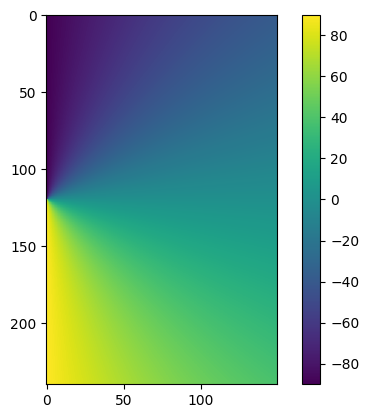

torch.Size([36000, 192])


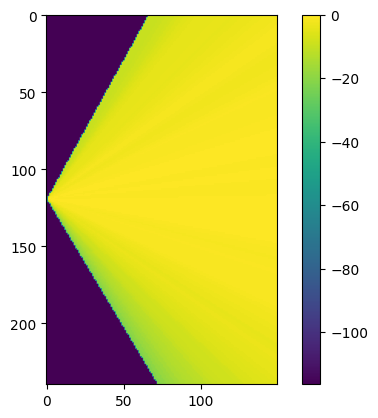

In [2]:
settings['limits'] = (-12,12,0,0,0,15)
settings['resolution'] = (240,1,150)
settings['coordinate type'] = 'cartesian'
pos = calc_pos(settings)

l=200
angle = torch.tensor(pickle.load(open('/home/dgotzens/recording/a02_angle.pkl', 'rb')))
gainmeas = pickle.load(open('/home/dgotzens/scripts/3.1_imaging/measured_gains/gains.pkl', 'rb'))[0]
print(gainmeas.shape)

flatpos = pos.flatten(0,-2)
print(flatpos.shape)
dists = flatpos.square().sum(-1).sqrt()
degs = 180/pi*torch.arctan(flatpos[:,0]/flatpos[:,2])
plt.imshow(degs.unflatten(0,settings['resolution']).squeeze())
plt.colorbar()
plt.show()

gain = torch.full((*settings['resolution'],K), 1e-6).flatten(0,-2)
print(gain.shape)

for i, (deg,dist) in enumerate(zip(degs,dists)):
    idx = int(deg+60)
    if 0<=idx<119:
        gain[i,:] = (gainmeas.abs()[:,idx] * 4*(dist**0))
settings['channel gain'] = gain.unflatten(0,settings['resolution'])
img = calc_image_hybrid(data[:,:,l], settings, pos)
plt.imshow(gain.unflatten(0,settings['resolution']).abs().mean(-1).squeeze().dBr())
plt.colorbar()


In [107]:
# for n in range(1000):
#     img = calc_image_hybrid(data[:,:,l], settings, pos)
#duriation 95.4s

In [3]:
pdf.setup()
# %matplotlib inline
plt.figure(layout='constrained')
plt.pcolormesh(img[:,0,:].T.abs().dBr(), vmin=-65, cmap='viridis', rasterized=True)
plt.gca().set_aspect('equal')
plt.colorbar(format=EngFormatter('dBr'), shrink=0.8)
X,_,Z = settings['resolution']

plt.xticks(torch.linspace(0,X,5).int(), [f'{pos.round()[x,0,0,0]}m' for x in torch.linspace(0,X-1,5).int()])
plt.xticks(torch.linspace(0,X,25), minor=True)
plt.xlabel('x')
plt.yticks(torch.linspace(0,Z,4).int(), [f'{pos.round()[0,0,z,2]}m' for z in torch.linspace(0,Z-1,4).int()])
plt.yticks(torch.linspace(0,Z,16), minor=True)
plt.ylabel('y')
plt.grid()
plt.grid(which='minor', linewidth=0.3)
plt.gcf().set_size_inches(0.8*pdf.a4_textwidth, 0.4*pdf.a4_textwidth)
plt.savefig('/home/dgotzens/thesis/figures/testimg_uncalibrated_hybrid.pdf')
# plt.show()

In [109]:
folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
calib = torch.load(folder+'schwenks_channelgains.pt')
img = calc_image_hybrid(data[:,:,l]/calib, settings, pos)


In [111]:
pdf.setup()
plt.figure(layout='constrained')
plt.pcolormesh(img[:,0,:].T.abs().dBr(), vmin=-65, cmap='viridis', rasterized=True)
plt.gca().set_aspect('equal')
plt.colorbar(format=EngFormatter('dBr'), shrink=0.8)
X,_,Z = settings['resolution']

plt.xticks(torch.linspace(0,X,5).int(), [f'{pos.round()[x,0,0,0]}m' for x in torch.linspace(0,X-1,5).int()])
plt.xticks(torch.linspace(0,X,25), minor=True)
plt.xlabel('x')
plt.yticks(torch.linspace(0,Z,4).int(), [f'{pos.round()[0,0,z,2]}m' for z in torch.linspace(0,Z-1,4).int()])
plt.yticks(torch.linspace(0,Z,16), minor=True)
plt.ylabel('y')
plt.grid()
plt.grid(which='minor', linewidth=0.3)
plt.gcf().set_size_inches(0.8*pdf.a4_textwidth, 0.4*pdf.a4_textwidth)
plt.savefig('/home/dgotzens/thesis/figures/testimg_calibrated_hybrid.pdf')